<a href="https://colab.research.google.com/github/arch1781993/Learning_Pytorch_DeepLearning/blob/main/6_CNN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST dataset

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
# Next before we import the data, we need to transform it. the images are 2d, but we need to be working in 4 dimensions,
# we need a tensor with 4 dimensions for (to track no of images, height, width and color channel)

# Convert MNIST image files into a tensor of 4 dimensions (# of images, height, width and color channel)
transform = transforms.ToTensor()

In [32]:
# train data
# MNIST data is already in datasets library, root = 'CNN_data' means we are saving locally on Colab, train = True means it is a training data
train_data = datasets.MNIST(root = '/CNN_data', train = True, download=True, transform=transform)

In [33]:
# test data
test_data = datasets.MNIST(root = '/CNN_data', train = False, download=True, transform=transform)

In [34]:
# Creating small batch size of images for loading, lets say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [35]:
# Define our model
# Describing convulutional layer and what it is doing (2 convulutional layers)
# This is just an example, later we will build the whole model
conv1 = nn.Conv2d(1,6,3,1)  # this is first convulutional layer: 1 input image, 6 outputs in featured map (with 6 filters), 3*3 kernel and 1 stride
                            # Here we have not defined padding (so the images will be reduced by 2 pixels) and we dont care since the digits are in the middle of the images
                            # and we dont care what is happening at the edges
conv2 = nn.Conv2d(6,16,3,1) # this is second convulutional layer: 6 input image (since there were 6 outputs from 1 con layer),
                            # 16 outputs in featured map, 3*3 kernel and 1 stride

In [36]:
# Grab 1 MNIST image
for i, (X_train,y_train) in enumerate(train_data):  # Here X_train is the actual image and y_train is the label associated with this
  break

In [37]:
X_train.shape # 1 iamge and size is 28*28 pixels

torch.Size([1, 28, 28])

In [38]:
# since we are working with 4d tensor, lets transform this image into 4 dimension
x = X_train.view(1,1,28,28)        # 1st batch, 1st image, 28 height, 28 width

In [39]:
# perform our first convolution
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function

In [40]:
x.shape      # 1st batch, 6 output (since there were 6 filters each 3*3), 26 height and 26 width

torch.Size([1, 6, 26, 26])

In [41]:
# Pass through the pooling layer
x = F.max_pool2d(x,2,2) # 2*2 kernel and 2 stride

In [42]:
x.shape # 26/2 = 13

torch.Size([1, 6, 13, 13])

In [43]:
# perform our second convolution
x = F.relu(conv2(x))

In [44]:
x.shape # this time 16 output (why not 6*16, since there are 16 filters?). In 2nd convulution
        # each of the 16 filters is not a flat 3*3 square. Instead, each filter is a 3D volume of 3*3*6.
        # One filter slides across all 6 input feature maps at the same time. It performs a calculation on all 6 layers and sums them together into one single value.

torch.Size([1, 16, 11, 11])

In [45]:
# 2nd pooling layer
x = F.max_pool2d(x,2,2)

In [46]:
x.shape # 11/2 = 5.5, round down to 5, because we cant invent data to round up to 6

torch.Size([1, 16, 5, 5])

In [47]:
# Model class
class convulutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully connected layer (see figure)
    self.fc1 = nn.Linear(16*5*5, 120) # 16*5*5 is the output from 2nd pooling and passing it to 120 neurons
    self.fc2 = nn.Linear(120, 84)     # From 120 neurons to 84 neurons
    self.fc3 = nn.Linear(84, 10)      # From 84 neurons to 10 neurons

  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)
    # Second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)

    # Re-view to flatten it out
    X = X.view(-1,16*5*5) # -1 so that we can vary the batch size

    # Fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1) # It turns the raw numbers coming out of your last linear layer into logarithmic probabilities. In simple terms, it tells you which digit (0–9) the AI thinks it is looking at.
                                   # The dim=1 Part, This tells PyTorch which "direction" to calculate the probability. Since your data is in batches,
                                   # your X looks like a table: Rows are the images, and Columns are the classes (0-9). dim=1 tells the computer:
                                   # "Calculate the probability across the columns (the classes) for each image."

In [48]:
# Create an instance
torch.manual_seed(41)
model = convulutionalNetwork()
model

convulutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [49]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001) # Smaller the LR, the longer it gonna take to train

In [50]:
import time
start_time = time.time()

# Create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop of epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2d
    loss = criterion(y_pred, y_train) # Compare the prediction to correct y

    predicted = torch.max(y_pred.data, 1)[1] # y_pred.data = This accesses the underlying tensor data of y_pred. In modern PyTorch, you can usually just use y_pred directly, but data is often used in older scripts to ensure the operation doesn't track gradients.
                                             # torch.max(..., 1) = The torch.max() function, when given a dimension (in this case, 1), returns two things: 1. The maximum values found along that dimension (the highest confidence scores). 2. The indices where those maximum values were found.
                                             # [1] at the end = Because torch.max returns a tuple of (values, indices), the [1] selects the second element of that tuple—the indices.
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True =1 , False = 0 and then we sum those up
    trn_corr += batch_corr # Keep track as we go along in training

    # update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out results
    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss:{loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad():
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


end_time = time.time()
total = end_time - start_time
print(f'Training took: {total/60} minutes!')

Epoch: 0  Batch: 600  Loss:0.1623610556125641
Epoch: 0  Batch: 1200  Loss:0.1502392590045929
Epoch: 0  Batch: 1800  Loss:0.4744560718536377
Epoch: 0  Batch: 2400  Loss:0.14238706231117249
Epoch: 0  Batch: 3000  Loss:0.007758188061416149
Epoch: 0  Batch: 3600  Loss:0.3836284875869751
Epoch: 0  Batch: 4200  Loss:0.0038223876617848873
Epoch: 0  Batch: 4800  Loss:0.0021286322735249996
Epoch: 0  Batch: 5400  Loss:0.0569545142352581
Epoch: 0  Batch: 6000  Loss:0.00038789428072050214
Epoch: 1  Batch: 600  Loss:0.005851339548826218
Epoch: 1  Batch: 1200  Loss:0.3855525553226471
Epoch: 1  Batch: 1800  Loss:0.004819948226213455
Epoch: 1  Batch: 2400  Loss:0.003216963727027178
Epoch: 1  Batch: 3000  Loss:0.0332382395863533
Epoch: 1  Batch: 3600  Loss:0.5372857451438904
Epoch: 1  Batch: 4200  Loss:0.04561494290828705
Epoch: 1  Batch: 4800  Loss:0.0007510822033509612
Epoch: 1  Batch: 5400  Loss:0.0001173773780465126
Epoch: 1  Batch: 6000  Loss:0.14201366901397705
Epoch: 2  Batch: 600  Loss:0.023733

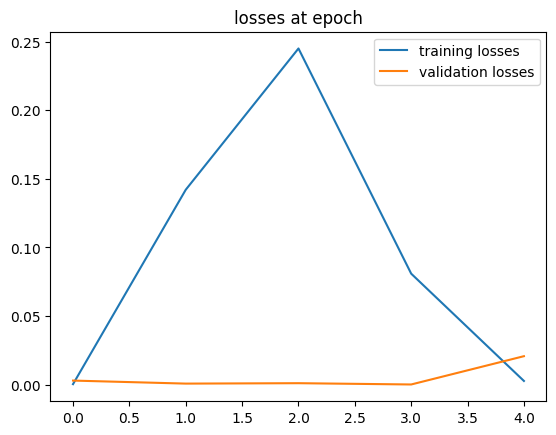

In [51]:
# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses] # train_losses is a tensor, converting that to a list, item() is a built-in method used to extract a standard Python number (like a float or int) from a tensor that contains a single value.
                                                  # [] converts that to a list
plt.plot(train_losses, label='training losses')
plt.plot(test_losses, label='validation losses')
plt.title('losses at epoch')
plt.legend()

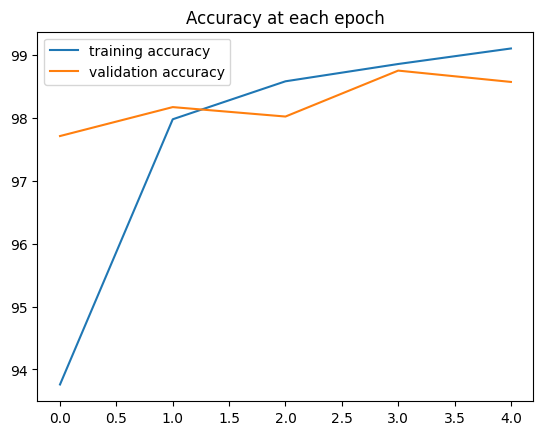

In [52]:
# Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label = 'training accuracy')
plt.plot([t/100 for t in test_correct], label = 'validation accuracy')
plt.title('Accuracy at each epoch')
plt.legend()

In [54]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [57]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()

In [58]:
correct.item() # 9857 are correct

9857

In [59]:
# in percentage
correct.item()/len(test_data)

0.9857

# Send new image through the model

In [60]:
# Grab an image
test_data[4143] # It has two components 1. tensor and 2. lable

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [61]:
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [62]:
test_data[4143][0].view(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

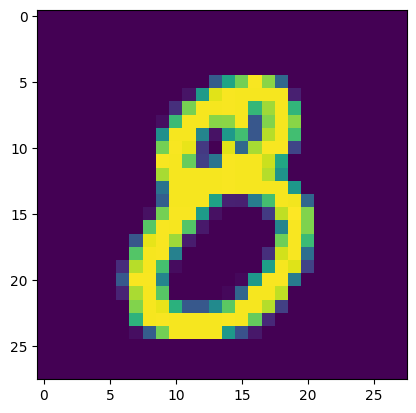

In [70]:
plt.imshow(test_data[4145][0].view(28,28))

In [71]:
# PAss the image through our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4145][0].view(1,1,28,28))

In [72]:
# Check the prediction
new_prediction # probability output, take the biggest one

tensor([[-1.4947e+01, -1.5897e+01, -1.6648e+01, -1.1991e+01, -1.6801e+01,
         -1.3131e+01, -1.5191e+01, -1.5879e+01, -1.0014e-05, -1.4021e+01]])

In [73]:
predicted = torch.max(new_prediction, 1)[1].item()

In [69]:
predicted

9